In [3]:
import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import os, time

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby
from tensorflow.keras import initializers
from tensorflow.python.keras.utils.layer_utils import count_params

# import wandb
# from wandb.keras import WandbCallback

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [2]:
!pip install opencv-python

     |████████████████████████████████| 60.9 MB 22.2 MB/s            


In [60]:
''''
here in this example we need to read the text document , and use the text document to generate the path 
for the model . for all the ok startus we are going to generate the text. 
'''

base_path = "./data"
# words_list = []

# words = open(f"{base_path}/words.txt", "r").readlines()

file_path=f"{base_path}/words.txt"
file_path_2=f"{base_path}/words"
# file_path="../input/iam-handwriting-word-database/words_new.txt"
with open(file_path) as f:
    lines = f.readlines()

label_raw=lines[18:]

image_texts =[]
image_paths =[]

default_path=file_path_2
# default_path="../input/iam-handwriting-word-database/iam_words/words/"
for label in label_raw:
  if label.split()[1]=="ok":
    image_texts.append(label.split()[-1])
    image_paths.append(default_path+"/"+label.split()[0].split("-")[0]+"/"+label.split()[0].split("-")[0]+"-"+label.split()[0].split("-")[1]+"/"+label.split()[0]+".png")

In [61]:
print("Length of image_texts", len(image_texts))
print("Length of image_paths", len(image_paths))

Length of image_texts 96456
Length of image_paths 96456


In [62]:
image_paths[0]

'./data/words/a01/a01-000u/a01-000u-00-00.png'

##### sample path 'data\\words\\e04\\e04-030\\e04-030-04-08.png'

In [63]:
corrupt_images = []

for path in image_paths:
    try:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    except:
        corrupt_images.append(path)

In [64]:
corrupt_images, len(corrupt_images)

(['./data/words/a01/a01-117/a01-117-05-02.png',
  './data/words/r06/r06-022/r06-022-03-05.png'],
 2)

In [65]:
# identify the index of the corrupted image
corrupt_index_1 = image_paths.index('./data/words/a01/a01-117/a01-117-05-02.png')
print(corrupt_index_1)

# remove the first corrupted impage: 'data\\words\\a01\\a01-117\\a01-117-05-02.png'
del image_paths[3600]
del image_texts[3600]

3600


In [66]:
# identify the index of the corrupted image
corrupt_index_2 = image_paths.index('./data/words/r06/r06-022/r06-022-03-05.png')
print(corrupt_index_2)

# remove the first corrupted impage:'data\\words\\r06\\r06-022\\r06-022-03-05.png'
del image_paths[94928]
del image_texts[94928]

94928


In [67]:
# Remaining data
print("Remaing Length of image_texts", len(image_texts))
print("Remaing Length of image_paths", len(image_paths))

Remaing Length of image_texts 96454
Remaing Length of image_paths 96454


In [68]:
# get vocabulary for the current dataset
vocab = set("".join(map(str, image_texts)))
print(sorted(vocab))

#get the max length of any text
max_label_len = max([len(str(text)) for text in image_texts])
print("max_label_len is", max_label_len)
print("length of vocab is ", len(vocab))

['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_label_len is 21
length of vocab is  78


In [69]:
char_list = sorted(vocab)


def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    #pad_sequences will fill in digit 78 (len(char_list)) to reach the max length of len(char_list) for each text label
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list))[0]

def inverse_encode(dig_y):
    word=""
    for i in range(len(dig_y)):
        # 21 elements in each encode_to_labels
        for j in range(21):
            if dig_y[i][j]!=78:
                char = char_list[dig_y[i]]
                word+=char
    return word

In [70]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[1]

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
       78, 78, 78, 78], dtype=int32)

In [71]:
# # use 90/10 train/test split to speed up training time

# train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
# train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

# val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
# val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

# #validate
# len(image_paths) ==len(val_image_paths)+len(train_image_paths)

(166, 78)


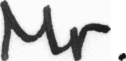

In [72]:
print(load_img(image_paths[3]).size)
load_img(image_paths[4])

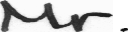

In [73]:
img = load_img(image_paths[4],target_size=(32,128))   
img

In [74]:
img = load_img(image_paths[4],target_size=(32, 128))
      
# transform image to array
img = img_to_array(img)

# stack images and trasnform to array
# images_stact = np.stack(images_mini)
y_lab = np.array(padded_image_texts[1]).flatten() 
y_lab

array([38, 40, 47, 30, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
       78, 78, 78, 78], dtype=int32)

In [75]:
len(padded_image_texts)

96454

In [76]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_update = []
    images_update = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for img in IMAGE_PATH:
        # read image
        img = load_img(image_paths[4],target_size=(32, 128))
        
        # transform image to array
        img = img_to_array(img)
        
        # append to images
        images_update.append(img)

    # stack images and trasnform to array
    images_update = np.stack(images_update)
#     y_update = np.array(LABEL_PATH).flatten()
    y_update = np.array(LABEL_PATH)  # did not flatten as it is multi output (21) for each label 
    
    return images_update, y_update

In [50]:
# generate images and labels based on preprocess_data_part1() function
images_update, y_update = preprocess_data_part1(image_paths, padded_image_texts)

print(f"images_update shape {images_update.shape}")
print(f"y_update shape {y_update.shape}")

images_update shape (96454, 32, 128, 3)
y_update shape (96454, 21)


In [51]:
def process_single_sample(img_path, label):

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [32, 128])
    
#     img = tf.transpose(img, perm=[1, 0, 2])
    return {"image": img, "label": label}

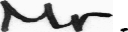

In [52]:
array_to_img(images_update[1]) 

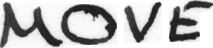

In [53]:
load_img(image_paths[1])  #original image sequence

### Preprocessing: Image transformation and augmentation

Metal device set to: Apple M2


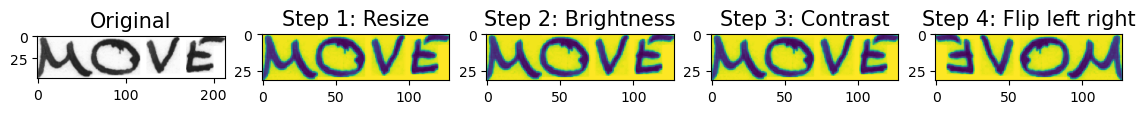

In [54]:
# use one example
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = load_img(image_paths[1])

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(image)
ax.set_title('Original', size=15);

#test the image transformation
img_io = tf.io.read_file(image_paths[1])

# # 2. Decode and convert to grayscale
img_io = tf.io.decode_png(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(img_io, size=(32, 128))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

In [55]:
# # same function but applies to the entire image path
# def process_group_sample(image_path):
    
#     img_path = []

#     for i in range(len(image_path)):
#         img = tf.io.read_file(image_path[i])

#         # 2. Decode and convert to grayscale
#         img = tf.io.decode_png(img, channels=1)

#         # 3. Convert to float32 in [0, 1] range
#         img = tf.image.convert_image_dtype(img, tf.float32)

#         # 4. Resize to the desired size
#         img = tf.image.resize(img, [32, 128])
    
#         img_path.append(img)
#         #     print(img_path)
#     return img_path

In [56]:
IMAGE_SIZE = (32, 128)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)  # need to update the shape
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to 
    # the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_update), split).astype(int)
    X_train, X_val, X_test = np.split(images_update, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_update, [splits[0], splits[0]+splits[1]])
    
    ## image transformation on training, validation, and test data ###
    ##################################################################
#     image resize (if the resize is different than (32, 128))
#     X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
#     X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
#     X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    # double the training size in this step
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### In the preprocess_data_part2 step, X_train size is double from 57872 to 115744, to include the X_train_augm data

In [57]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_update,
    y_update,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (115744, 32, 128, 1)
y_train shape (115744, 21)
X_val shape (19290, 32, 128, 1)
y_val shape (19290, 21)
X_test shape (19292, 32, 128, 1)
y_test shape (19292, 21)


In [58]:
y_train[0]

array([55, 56, 52, 71, 59, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,
       78, 78, 78, 78], dtype=int32)

Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()
X_train_reshape = X_train[:8000].reshape(8000, 4096)
Y_train_reshape = np.argmax(y_train[:8000], axis=1)

clf = LogisticRegression(random_state=0).fit(X_train_reshape, Y_train_reshape)

/Users/mrsca/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Experiment Scikit-learn model

### LogisticRegression

In [89]:
# scikit-learn model

from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# Text clearning
# import neattext.functions as nfx

# transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# #Build a pipeline

# # use ('cv', CountVectorizer()) to convert text
# # pipe_lr = Pipeline(steps=[('cv', CountVectorizer()),
# #                          ('lr_multi',MultiOutputClassifier(LogisticRegression()))])

# pipe_lr = Pipeline(steps=[('lr_multi',MultiOutputClassifier(LogisticRegression()))])

# # sciki learn expects 2-D dimension
# X_train_sk = np.array(X_train).reshape(-1,4096)
# Y_train_sk = np.array(Y_train)

# # Fit the model
# pipe_lr.fit(X_train_sk, Y_train_sk)

In [ ]:
# # sciki learn expects 2-D dimension
# X_test_sk = np.array(X_test).reshape(-1,4096)
# X_test_sk = np.array(Y_test)

In [ ]:
# print("Linear Regression Training Accuracy is:", pipe_lr.score(X_test_sk, X_test_sk))
# print("Linear Regression Test Accuracy is:", pipe_lr.score(X_test_sk, X_test_sk))

In [ ]:
# # Predict one example
# ex1 = X_test_sk.iloc[0]
# print(pipe_lr.predict([ex1]))

# #print predicted class and Probability
# print(pipe_lr.classes([ex1]))
# print(pipe_lr.predict_proba([ex1]))

In [90]:
# alternative codes for scikit-learn LR model

X = X_train[:8000]
y = y_train[:8000]

X, y = make_multilabel_classification(n_samples=8000, n_features=4096,
                                      n_classes=21, random_state=0)
sk_lr = MultiOutputClassifier(LogisticRegression()).fit(X, y)

In [91]:
# Fit the model
sk_lr.fit(X, y)

MultiOutputClassifier(estimator=LogisticRegression())

In [92]:
# reshape to 2-D
X_train_rs = tf.reshape(X_train, [-1,4096])
X_val_rs = tf.reshape(X_val, [-1,4096])
X_test_rs = tf.reshape(X_test, [-1,4096])

X_train_rs.shape

TensorShape([115744, 4096])

In [93]:
# Score the traing data
sk_lr.score(X, y)

0.991125

In [ ]:
y_train[:1]

In [ ]:
X[:1]

In [97]:
y[:1]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [94]:
predict_1 = sk_lr.predict(X[:1])
print(predict_1)

[[0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]]


In [95]:
#prediction
pre_val = sk_lr.predict(X_train_rs[:1000])
pre_val

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [96]:
#score accuracy
sk_lr.score(X_val_rs[:8000], y_val[:8000])

0.0

In [ ]:
# # Predict one example
ex2 = X_test_re[0]
print(sk_lr.predict([ex2]))

#print predicted class and Probability
# print(sk_lr.classes([ex2]))
print(sk_lr.predict_proba([ex2].shape))

###  Several Other ML Estimators that support multi-output
- KNN
- Random Forest
- Decision Tree

## Random Forest

## Warning: DOES NOT FINISH the run even with 1000 images

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


In [ ]:
# Fitting Random Forest Classification to the Training set, 32 x 128 = 4096
sk_rf = RandomForestClassifier(n_estimators = 4096, criterion = 'entropy', random_state = 42)
multi_target_forest = MultiOutputClassifier(sk_rf)

multi_target_forest.fit(X_train_re, Y_train_re)

In [ ]:
predictions = multi_target_forest.predict(X_test_re)
assert_equal((n_samples, n_outputs), predictions.shape)

predict_proba = multi_target_forest.predict_proba(X)

assert len(predict_proba) == n_outputs
for class_probabilities in predict_proba:
    assert_equal((n_samples, n_classes), class_probabilities.shape)

assert_array_equal(np.argmax(np.dstack(predict_proba), axis=1),
                   predictions)

In [ ]:
# Random Forecast model function
# def test_multi_output_classification(X, y, n_estimators = 4096):
#     # test if multi_target initializes correctly with base estimator and fit
#     # assert predictions work as expected for predict, prodict_proba and score

#     forest = RandomForestClassifier(n_estimators=n_estimators, random_state=1)
#     multi_target_forest = MultiOutputClassifier(forest)

#     # train the multi_target_forest and also get the predictions.
#     multi_target_forest.fit(X, y)

#     predictions = multi_target_forest.predict(X)
#     assert_equal((n_samples, n_outputs), predictions.shape)

#     predict_proba = multi_target_forest.predict_proba(X)

#     assert len(predict_proba) == n_outputs
#     for class_probabilities in predict_proba:
#         assert_equal((n_samples, n_classes), class_probabilities.shape)

#     assert_array_equal(np.argmax(np.dstack(predict_proba), axis=1),
#                        predictions)

#     # train the forest with each column and assert that predictions are equal
#     for i in range(3):
#         forest_ = clone(forest)  # create a clone with the same state
#         forest_.fit(X, y[:, i])
#         assert_equal(list(forest_.predict(X)), list(predictions[:, i]))
#         assert_array_equal(list(forest_.predict_proba(X)),
#                            list(predict_proba[i]))

## Warning: KNN below takes a very long time to run!

### KNN Regression

In [ ]:
# # Build the KNN model pipeline

# pipe_lr = Pipeline(steps=[('knn',KNeighborsClassifier(n_neighbors=5))])  #try 5 neighbors

In [ ]:
# # KNN model
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

# clf_kn = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=101)).fit(X, y)
# clf_kn.predict(X)
# clf_kn.score(X, y)

In [ ]:
# result_kn = clf_kn.predict(X_test[-1])
# print("Prediction for the last sample", result_kn)
# # KNN Regression model accuracy
# print("KNN Traing Accuracy is:", clf_kn.score(X, y)
# print("KNN Test Accuracy is:", clf_kn.score(X_test, Y_test)

## Experiment Keras Multiclassification Model

In [ ]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.
    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.
    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # first layer: input shape of the dataset
    input1 = keras.layers.Input(shape=(32, 128), name='Input')
    
    # second layer: flatten to transforms the format of the images to a 1D array of 28*28 = 784 pixels
    # this layer has no params or weights to learn, it only reformats data
    input2 = keras.layers.Flatten(name='Flatten')(input1)
    
    # add layers based on hidden_layer_sizes
    inputs_layer = input2
    activation = activation
    for i in range(len(hidden_layer_sizes)):
        input = keras.layers.Dense(hidden_layer_sizes[i], activation = activation, name=f'Hidden_Layer_{i}')(inputs_layer)
        inputs_layer = input  
  
    # next layer: dropout. Makes it so some of the nodes in a given layer don’t pass on their information to the next layer
    # This helps with computation time (less parameters) and with overfitting.
    # Each node in this layer has a 0.3 probability of being dropped from the computation of the activations of 
    # the next layer
    input_dropout = keras.layers.Dropout(rate=0.3, name='Dropout')(inputs_layer) 
    
    #the last layer is the output layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # logits = natural logarithm of the odds ratio
    # set units= n_classes for multiple classification problem)
    out = keras.layers.Dense(units=n_classes, activation= None, name='Layer_output')(input_dropout)
    
    # Alternative:  out = keras.layers.Dense(units=n_classes, activation='softmax', name='Layer_output')(input_dropout) 
    # if activation is set to "softmax", then take out (from_logits=True) in the model.compile function
    
    model = keras.models.Model(inputs=input1, outputs=out)
   
    if optimizer=='SGD':
        optimizers = keras.optimizers.SGD(learning_rate=0.01)
    elif optimizer=='Adam':
        optimizers = keras.optimizers.Adam(learning_rate=0.01)
    else:
        raise ValueError('Invalid optimizer: %s' % optimizer)
    
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        optimizer=optimizers,
        metrics=['accuracy'])
    
    return model

In [ ]:
#show model summmary
# model = build_model(n_classes = 21, hidden_layer_sizes=[2048, 1024,512, 256,64])
model = build_model(n_classes = 21, hidden_layer_sizes=[])
model.summary()

In [ ]:
X_train.shape

In [ ]:
X_train_mini = np.array(X_train[:8000])
y_train_mini = np.array(y_train[:8000])

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

history_img= model.fit(x=X_train,
                y=y_train,
                validation_split=0.1, # set 10% of train data for validation
                batch_size=1000,
#                 batch_size=len(X_train),
                epochs=16,
#                 verbose=0  # fit quitely 
               )

In [ ]:
hist_img = history_img.history
x_arr_img = np.arange(len(hist_img['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr_img, hist_img['loss'], '-o', label='Train loss')
ax.plot(x_arr_img, hist_img['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr_img, hist_img['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr_img, hist_img['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_ylim(0,1)
plt.show()

In [ ]:
test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0, return_dict=True)['accuracy']
test_accuracy

In [ ]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=10,
                       batch_size= 1000):
  """ train and evaluate"""
  start_line = f'Hidden_layer:{hidden_layer_sizes}\\Activation:{activation}\\Optimizer:{optimizer}\\batch_size:{batch_size}\\Learning_Rate: {learning_rate}\\ epochs:{num_epochs}'
  print(f'******************************************')
  print(f'\n\nTrain and Evaluate with: {start_line}')

  start_time = time.time()
  # Build the model.
  model = build_model(n_classes=21,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  history = model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=y_test, verbose=0,
                                 return_dict=True)['accuracy']
  total_train_param = sum(count_params(layer) for layer in model.trainable_weights)
  
  time_elapsed = round(time.time() - start_time, 1)
  print(f'Taining time is {time_elapsed} in seconds. Total trainable parameters are: {total_train_param}. Test accuracy: %1.4f' %test_accuracy)

  return test_accuracy

# print('Test Accuracy: %1.4f' %train_and_evaluate())

run_1 = train_and_evaluate()

### Run experiments 

In [ ]:
hidden_sizes =[[],[1024, 512],[2048,1024, 512]]
activation =['tanh','relu']
# optimizer = ['SGD','Adam']
optimizer = ['Adam']
num_epochs= [10, 20]
batch_size= [1000, 2000]

for i in hidden_sizes:
    for a in activation:
        for o in optimizer:
            for n in num_epochs:
                for b in batch_size:
                    train_and_evaluate(hidden_layer_sizes=i,
                                       activation=a,
                                       optimizer=o,
                                       learning_rate=0.01,
                                       num_epochs=n,
                                      batch_size=b)   

#  The modes below are from Kaggle, these can't be run as it.  I sent you the Kaggle workbook a week or so ago, if you want to run it with your GPU

### Kaggle CV model


In [ ]:
batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [ ]:
# use element_spec to check the elements
print(train_dataset.element_spec['image'])
print(train_dataset.element_spec['label'])

In [ ]:
for X,y in train_dataset.as_numpy_iterator():
    print("Shape of X, y")
    print(X, y)
    print(type(X), type(y))
    break # to avoid iterating over all the training examples

In [ ]:
df[1]

In [ ]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")

        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()

In [ ]:
## Ref: https://keras.io/examples/vision/captcha_ocr/

class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [ ]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [ ]:
def train(epochs):
    
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)
    
    conv_5 = Conv2D(512, (3,3), activation = "selu", padding='same')(conv_4)
    conv_6 = Conv2D(512, (3,3), activation = "selu", padding='same')(conv_5)
    drop_out=tf.keras.layers.Dropout(0.2)(conv_6)
    conv_7 = Conv2D(512, (3,3), activation = "selu", padding='same')(drop_out)
    conv_8 = Conv2D(512, (3,3), activation = "selu", padding='same')(conv_7)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_8)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
        
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(CuDNNLSTM(512, return_sequences=True))(blstm_1)
    blstm_3 = Bidirectional(CuDNNLSTM(512, return_sequences=True))(blstm_2)
    blstm_4 = Bidirectional(CuDNNLSTM(512, return_sequences=True))(blstm_3)
    blstm_5 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_4)
    dense_=Dense(128,activation = 'relu')(blstm_5)
    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(dense_)

    output = CTCLayer(name="ctc_loss",)(labels, softmax_output)


    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer,metrics=[tf.keras.metrics.Accuracy()])

    print(model.summary())
    file_path = "/kaggle/working/C_LSTM_best.hdf5"
    
    checkpoint = ModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

#     callbacks_list = [checkpoint, 
#                       WandbCallback(monitor="val_loss", 
#                                     mode="min", 
#                                     log_weights=True),
#                       PlotPredictions(frequency=1),
#                       EarlyStopping(patience=3, verbose=1)]

    history = model.fit(train_dataset, 
                        epochs = epochs,
                        validation_data=validation_dataset,
                        verbose = 1,
                        shuffle=True)
    
    return model

In [ ]:
# need to change the epoch
model = train(epochs=100)

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig , ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
plt.show()

In [ ]:


def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    # input with shape of height=32 and width=128 
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
    model.add(tf.keras.Input(shape=(num_features), name='image'))
    
    
    
    # create output layer
    model.add(keras.layers.Dense(
          units=21,  # remember it's a multiclass classification problem
          use_bias=True,
          activation='softmax', # remembeit's a multiclass classification problem
          kernel_initializer=initializers.RandomNormal(stddev=0.01),
          bias_initializer=initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
  # Use Categorical Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy']
    )
    return model

# Build a model
model = build_model(num_features=(32,128,1))
model.summary()

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model

history = model.fit(train_dataset, 
                    validation_data=validation_dataset,
                    epochs=1,
                    verbose = 1,
                    shuffle=True)